In [1]:
%load_ext autoreload
%autoreload 2

import tonic, torch, os
from hots.network import network
from hots.utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Numbe r of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

Tonic version installed -> 1.0.19
Numbe r of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [2]:
#device = "cpu"
device = "cuda"

In [3]:
drop_events_mlr = True
drop_proba = .5

kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)

name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold) 
    
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 1e6

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=False, verbose=False)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=True, verbose=False)
hots_nohomeo.coding(testloader, testset.ordering, testset.classes, filtering_threshold = filtering_threshold, training=False, jitter=jitter, verbose=False)

print('coding -> done')

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)

score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

print(f'Histogram accuracy with homeo: {score*100}% - without homeo: {score_nohomeo*100}%')

coding -> done
Histogram accuracy with homeo: 95.0% - without homeo: 94.39%


In [4]:
trainoutputloader = get_loader(trainset_output, kfold=1000)
num_sample_train = len(trainoutputloader)

number of samples in the testing set: 10
Mean accuracy: 62.2%
for tau cla: 1000000.0 - last accuracy: 60.0% - mean accuracy: 62.15587335616617%


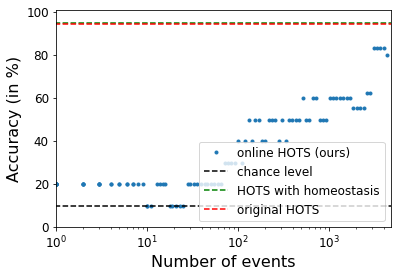

In [7]:
testoutputloader = get_loader(testset_output, kfold=1000, shuffle=False)
num_sample_test = len(testoutputloader)
print(f'number of samples in the testing set: {num_sample_test}')
#if drop_events_mlr:
#    drop_transform = tonic.transforms.DropEvent(p = drop_proba)
#    trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))

model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), device = device)
likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering)
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, figure_name = 'nmnist_online.pdf')
print(f'for tau cla: {tau_cla} - last accuracy: {lastac*100}% - mean accuracy: {meanac*100}%')

In [6]:
for l in range(len(likelihood)):
    for i in range(likelihood[l].shape[1]):
        plt.plot(likelihood[l][:,i])
    plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
kfold_jitter = 10
nb_trials = 1
nb_points = 20

standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, fitting = False)

standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, fitting = False)

In [ ]:
import matplotlib.pyplot as plt
kernels = classif_layer.linear.weight.data.cpu().numpy()
fig, ax = plt.subplots(N_output_neurons, kernels.shape[0], figsize=(30, 90))
for n in range(kernels.shape[0]):
    kernel = kernels[n].reshape(trainset.sensor_size[0],trainset.sensor_size[1], N_output_neurons)
    for p in range(N_output_neurons):
        ax[p, n].imshow(kernel[:,:,p])

In [ ]:
from hots.timesurface import timesurface

for i in range(100):
    events, label = next(iter(loader))
    X, ind_filtered = timesurface(events.squeeze(0).squeeze(0), (ts_size[0], ts_size[1], ts_size[2]), trainset_output.ordering, tau = tau_cla)
    print(X.shape)